In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8" # 0.9 causes too much lag. 
os.environ['MUJOCO_GL'] = 'egl'

os.environ['JAX_LOG_COMPILES'] = '0'

import time

import functools

import jax.numpy as jp
import numpy as np
import jax
print("JAX Device:", jax.devices())
from jax import config # Analytical gradients work much better with double precision.
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', 'high')

print("jax.devices():", jax.devices())
print("local_device_count:", jax.local_device_count())

from absl import logging
logging.set_verbosity(logging.DEBUG)

from mujoco_playground import registry
from mujoco_playground import wrapper
from mujoco_playground.config import locomotion_params

# from brax.training.agents.apg import train as apg
from apg_alg.algorithm import apg  # Local modified APG version # type: ignore
from brax.training.agents.apg import networks as apg_networks

from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo

from brax.envs.wrappers import training as brax_training

from brax.training import acting

from brax.io import model

from brax import envs

import matplotlib.pyplot as plt
from IPython.display import HTML, clear_output
from datetime import datetime
import mediapy as media

import wandb

env_name = "Go2Trot"
env_cfg = registry.get_default_config(env_name)

JAX Device: [CudaDevice(id=0), CudaDevice(id=1)]
jax.devices(): [CudaDevice(id=0), CudaDevice(id=1)]
local_device_count: 2


DEBUG:absl:Created `ArrayHandler` with primary_host=0, replica_id=0, use_replica_parallel=True, array_metadata_store=<orbax.checkpoint._src.metadata.array_metadata_store.Store object at 0x7efc0856a6d0>
DEBUG:absl:Handler "orbax.checkpoint._src.handlers.base_pytree_checkpoint_handler.BasePyTreeCheckpointHandler" already exists in the registry with associated type <class 'orbax.checkpoint._src.handlers.base_pytree_checkpoint_handler.BasePyTreeCheckpointHandler'>. Skipping registration.
DEBUG:absl:Handler "orbax.checkpoint._src.handlers.array_checkpoint_handler.ArrayCheckpointHandler" already exists in the registry with associated type <class 'orbax.checkpoint._src.handlers.array_checkpoint_handler.ArrayCheckpointHandler'>. Skipping registration.
DEBUG:absl:Handler "orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonCheckpointHandler" already exists in the registry with associated type <class 'orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonCheckpointHandler'>. Skipping

In [2]:
env_cfg

Kd: 0.5
Kp: 80.0
ctrl_dt: 0.02
env:
  action_scale:
  - 0.2
  - 0.8
  - 0.8
  - 0.2
  - 0.8
  - 0.8
  - 0.2
  - 0.8
  - 0.8
  - 0.2
  - 0.8
  - 0.8
  err_threshold: 0.1
  reset2ref: true
  step_k: 13
  termination_height: 0.1
episode_length: 240
impl: jax
nconmax: 32768
njmax: 40
rewards:
  scales:
    base_tracking: -1.0
    feet_height: -10.0
    min_reference_tracking: -0.0075
    reference_tracking: -10.0
sim_dt: 0.002

In [3]:
def render_rollout(reset_fn, step_fn, env, batch_size, inference_fn, n_step, render_every, seed=0):
    rng = jax.random.PRNGKey(seed)
    rngs = jax.random.split(rng, batch_size) 
    state = reset_fn(rngs)
    rollout_list = [state]
    rewards = 0.0
    print("Starting rollout...")
    for i in range(n_step):
        act_rng, rng = jax.random.split(rng)
        action, _ = inference_fn(state.obs, act_rng)
        state = step_fn(state, action)
        # state.info['steps'] += 1
        if state.done:
            print(f"Early termination at step {i+1}")
            print(state.info)
            break
        rollout_list.append(state)
        rewards += state.reward
    print(f"Total reward: {float(rewards[0]):.1f}")
    final_state = state
    traj = rollout_list[::render_every]
    fps = 1.0 / (env.dt * render_every)
    frames = env.render(traj, height=480, width=640)
    media.show_video(frames, fps=fps, loop=True)

    return final_state

## training APG

In [4]:
apg_env_cfg = registry.get_default_config(env_name)
apg_env_cfg['env']['reset2ref'] = False
env = registry.load(env_name, apg_env_cfg)
eval_env = registry.load(env_name, apg_env_cfg)

In [5]:
env.play_ref_motion(render_every=1)

Playing reference motion...


100%|██████████| 26/26 [00:00<00:00, 266.50it/s]


Rendered 26 frames at 50.0 FPS.


[array([[[ 39,  65,  92],
         [ 39,  66,  92],
         [ 39,  66,  92],
         ...,
         [ 39,  65,  92],
         [ 39,  65,  92],
         [ 39,  65,  92]],
 
        [[ 39,  65,  92],
         [ 39,  65,  92],
         [ 39,  65,  92],
         ...,
         [ 39,  65,  92],
         [ 39,  65,  92],
         [ 39,  65,  92]],
 
        [[ 39,  65,  92],
         [ 39,  65,  92],
         [ 39,  65,  92],
         ...,
         [ 39,  65,  91],
         [ 39,  65,  91],
         [ 39,  65,  91]],
 
        ...,
 
        [[ 62,  91, 122],
         [ 62,  91, 122],
         [ 62,  91, 122],
         ...,
         [ 62,  91, 123],
         [ 62,  91, 123],
         [ 62,  91, 123]],
 
        [[ 62,  91, 122],
         [ 62,  91, 122],
         [ 62,  91, 122],
         ...,
         [ 62,  91, 123],
         [ 62,  91, 123],
         [ 62,  91, 123]],
 
        [[ 62,  91, 122],
         [ 62,  91, 122],
         [ 62,  91, 122],
         ...,
         [ 62,  91, 123],
  

In [6]:
apg_params = locomotion_params.brax_apg_config(env_name)
print(apg_params)

action_repeat: 1
episode_length: 240
horizon_length: 32
learning_rate: 0.0001
max_gradient_norm: 1000000000.0
network_factory:
  hidden_layer_sizes: !!python/tuple
  - 256
  - 128
normalize_observations: true
num_envs: 64
num_eval_envs: 64
num_evals: 11
policy_updates: 499
use_float64: true



In [41]:
apg_params["policy_updates"] = 2000
# apg_params["num_envs"] = 512
apg_params["deterministic_eval"] = False
apg_params["num_envs"] = 64
apg_params["num_eval_envs"] = 64
apg_params["horizon_length"] = 24

print(apg_params)

action_repeat: 1
deterministic_eval: false
episode_length: 240
horizon_length: 24
learning_rate: 0.0001
max_gradient_norm: 1000000000.0
network_factory:
  hidden_layer_sizes: !!python/tuple
  - 256
  - 128
normalize_observations: true
num_envs: 64
num_eval_envs: 64
num_evals: 11
policy_updates: 2000
use_float64: true



In [42]:
apg_training_params = dict(apg_params)
network_factory = apg_networks.make_apg_networks
if "network_factory" in apg_params:
    del apg_training_params["network_factory"]
    network_factory = functools.partial(
        apg_networks.make_apg_networks, 
        **apg_params.network_factory)

train_fn = functools.partial(
    apg.train, **dict(apg_training_params),
    network_factory=network_factory)

wandb.init(project="mujoco-playground-apg-go2", name=f"apg_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

INFO:absl:Device count: 2, process count: 1 (id 0), local device count: 2, devices to be used count: 2
INFO:absl:{'eval/walltime': 42.15583157539368, 'eval/episode_base_tracking': Array(-43.21525681, dtype=float64), 'eval/episode_feet_height': Array(-273.66606943, dtype=float64), 'eval/episode_min_reference_tracking': Array(-15.7225363, dtype=float64), 'eval/episode_reference_tracking': Array(-37.70449757, dtype=float64), 'eval/episode_reward': Array(-370.30836011, dtype=float64), 'eval/episode_base_tracking_std': Array(5.189371, dtype=float64), 'eval/episode_feet_height_std': Array(0.79337418, dtype=float64), 'eval/episode_min_reference_tracking_std': Array(0.21432721, dtype=float64), 'eval/episode_reference_tracking_std': Array(8.23344972, dtype=float64), 'eval/episode_reward_std': Array(13.43281366, dtype=float64), 'eval/avg_episode_length': Array(240., dtype=float64), 'eval/std_episode_length': Array(0., dtype=float64), 'eval/epoch_eval_time': 42.15583157539368, 'eval/sps': 364.362

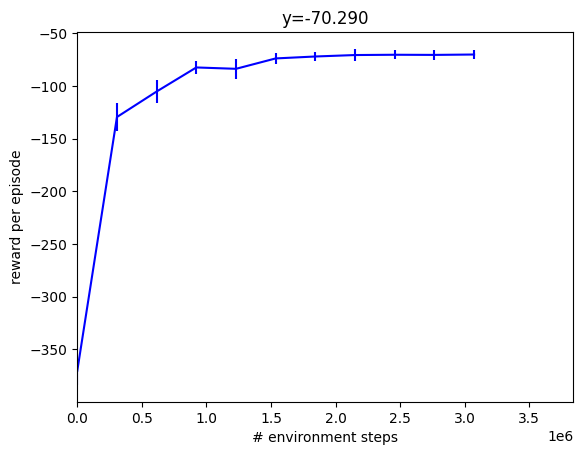

time to jit: 0:00:46.298539
time to train: 0:23:28.510387


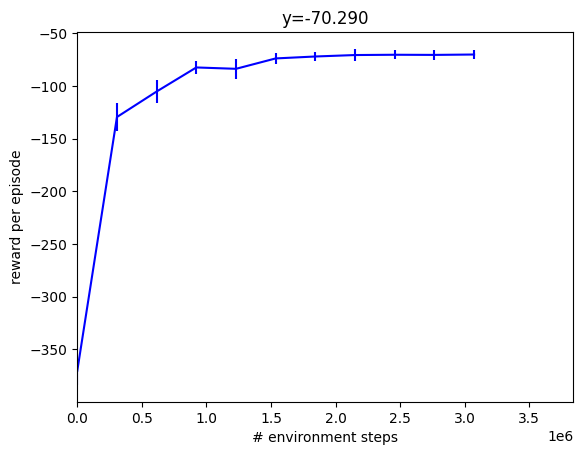

In [43]:
from datetime import datetime
x_data_apg = []
y_data_apg = []
ydataerr_apg = []
times_apg = [datetime.now()]

num_timesteps = apg_params["policy_updates"] * apg_params["horizon_length"] * apg_params["num_envs"] * apg_params["action_repeat"]
updates_per_epoch = round(apg_params["policy_updates"] / max(apg_params["num_evals"] - 1, 1))
scale_it = updates_per_epoch * apg_params["horizon_length"] * apg_params["num_envs"] * apg_params["action_repeat"]

def progress_apg(num_steps, metrics):

    times_apg.append(datetime.now())
    x_data_apg.append(num_steps * scale_it)
    y_data_apg.append(metrics["eval/episode_reward"])
    ydataerr_apg.append(metrics["eval/episode_reward_std"])
    wandb.log(metrics,step=num_steps * scale_it)

make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=eval_env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
    progress_fn=progress_apg
)

wandb.finish()

plt.xlim([0, num_timesteps * 1.25])
plt.xlabel("# environment steps")
plt.ylabel("reward per episode")
plt.title(f"y={y_data_apg[-1]:.3f}")
plt.errorbar(x_data_apg, y_data_apg, yerr=ydataerr_apg, color="blue")
display(plt.gcf())

print(f"time to jit: {times_apg[1] - times_apg[0]}")
print(f"time to train: {times_apg[-1] - times_apg[1]}")

In [44]:
demo_cfg = registry.get_default_config(env_name)
demo_cfg['env']['reset2ref'] = False
demo_env = registry.load(env_name, demo_cfg)
demo_env = brax_training.VmapWrapper(demo_env)
demo_step_fn = jax.jit(demo_env.step)
demo_reset_fn = jax.jit(demo_env.reset)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=False))

final_state = render_rollout(
    demo_reset_fn, demo_step_fn, demo_env, 1,
    jit_inference_fn, n_step=1002, render_every=3, seed=42)

Starting rollout...
Total reward: -299.9


100%|██████████| 335/335 [00:01<00:00, 311.95it/s]


In [11]:
from brax.io import model
model_path = '/tmp/trotting_apg_2hz_policy'
model.save_params(model_path, params)

## training PPO

In [4]:
ppo_env_cfg = registry.get_default_config(env_name)
ppo_env_cfg['env']['reset2ref'] = True
env = registry.load(env_name, ppo_env_cfg)
eval_env = registry.load(env_name, ppo_env_cfg)

In [5]:
ppo_params = locomotion_params.brax_ppo_config(env_name)
print(ppo_params)

action_repeat: 1
batch_size: 1024
discounting: 0.97
entropy_cost: 0.001
episode_length: 240
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: !!python/tuple
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: !!python/tuple
  - 512
  - 256
  - 128
  value_obs_key: state
normalize_observations: true
num_envs: 1024
num_evals: 10
num_minibatches: 32
num_resets_per_eval: 10
num_timesteps: 10000000
num_updates_per_batch: 8
reward_scaling: 0.1
unroll_length: 32



In [6]:
wandb.init(project="mujoco-playground-ppo-go2", name=f"ppo_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

wandb: Currently logged in as: mayuxuan2004 (mayuxuan2004-shanghaitech-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# ppo_params["num_envs"] = 512
ppo_params["num_timesteps"] = 1_000_000
ppo_params["episode_length"] = 240
print(ppo_params)
# ppo_params = locomotion_params.brax_ppo_config("AnymalTrot")
ppo_training_params = dict(ppo_params)
ppo_network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
    del ppo_training_params["network_factory"]
    ppo_network_factory = functools.partial(
        ppo_networks.make_ppo_networks,
        **ppo_params.network_factory
    )

x_data_ppo = []
y_data_ppo = []
ydataerr_ppo = []
times_ppo = [datetime.now()]

def progress_ppo(num_steps, metrics):

    times_ppo.append(datetime.now())
    x_data_ppo.append(num_steps)
    y_data_ppo.append(metrics["eval/episode_reward"])
    ydataerr_ppo.append(metrics["eval/episode_reward_std"])
    wandb.log(metrics,step=num_steps)
    print(f"Step {num_steps}")
    print()

train_ppo_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=ppo_network_factory,
    progress_fn=progress_ppo
)

action_repeat: 1
batch_size: 1024
discounting: 0.97
entropy_cost: 0.001
episode_length: 240
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: !!python/tuple
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: !!python/tuple
  - 512
  - 256
  - 128
  value_obs_key: state
normalize_observations: true
num_envs: 1024
num_evals: 10
num_minibatches: 32
num_resets_per_eval: 10
num_timesteps: 1000000
num_updates_per_batch: 8
reward_scaling: 0.1
unroll_length: 32



INFO:absl:Device count: 2, process count: 1 (id 0), local device count: 2, devices to be used count: 2
INFO:absl:{'eval/walltime': 55.67653703689575, 'eval/episode_base_tracking': Array(-254.30744795, dtype=float64), 'eval/episode_feet_height': Array(-489.40854018, dtype=float64), 'eval/episode_min_reference_tracking': Array(-64.78155941, dtype=float64), 'eval/episode_reference_tracking': Array(-895.82638, dtype=float64), 'eval/episode_reward': Array(-1704.32392754, dtype=float64), 'eval/episode_base_tracking_std': Array(15.82464647, dtype=float64), 'eval/episode_feet_height_std': Array(19.27766768, dtype=float64), 'eval/episode_min_reference_tracking_std': Array(1.12760754, dtype=float64), 'eval/episode_reference_tracking_std': Array(67.83675207, dtype=float64), 'eval/episode_reward_std': Array(84.50793531, dtype=float64), 'eval/avg_episode_length': Array(240., dtype=float64), 'eval/std_episode_length': Array(0., dtype=float64), 'eval/epoch_eval_time': 55.67653703689575, 'eval/sps': 5

time to jit: 0:01:21.804046
time to train: 0:38:47.678904

Final metrics:
 {'eval/walltime': 75.47465014457703, 'training/sps': np.float64(420792.31993670925), 'training/walltime': 2293.400374889374, 'training/entropy_loss': Array(0.01993597, dtype=float64), 'training/policy_loss': Array(-0.00056914, dtype=float64), 'training/total_loss': Array(0.01963821, dtype=float64), 'training/v_loss': Array(0.00027138, dtype=float64), 'eval/episode_base_tracking': Array(-23.01424365, dtype=float64), 'eval/episode_feet_height': Array(-59.20423937, dtype=float64), 'eval/episode_min_reference_tracking': Array(-9.82906244, dtype=float64), 'eval/episode_reference_tracking': Array(-14.1184031, dtype=float64), 'eval/episode_reward': Array(-106.16594856, dtype=float64), 'eval/episode_base_tracking_std': Array(2.3866197, dtype=float64), 'eval/episode_feet_height_std': Array(0.68211968, dtype=float64), 'eval/episode_min_reference_tracking_std': Array(0.10912553, dtype=float64), 'eval/episode_reference_trac

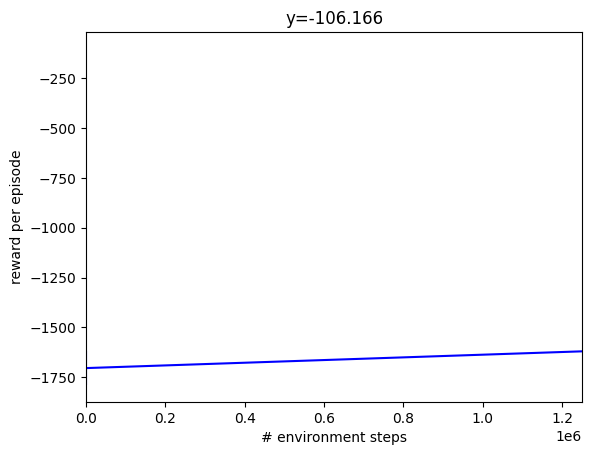

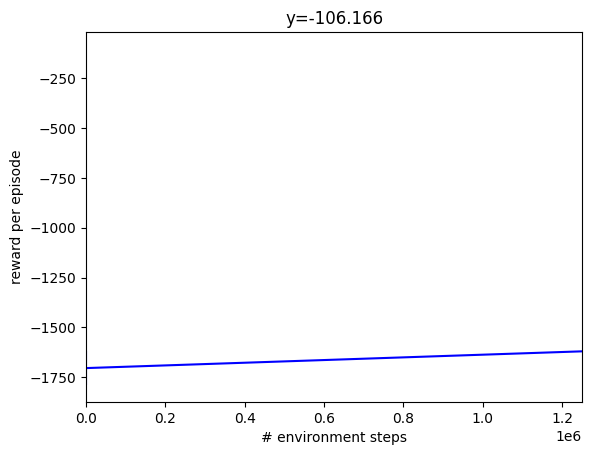

In [8]:
make_ppo_inference_fn, inference_ppo_params, metrics = train_ppo_fn(
    environment=env,
    eval_env=eval_env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)

wandb.finish()

print(f"time to jit: {times_ppo[1] - times_ppo[0]}")
print(f"time to train: {times_ppo[-1] - times_ppo[1]}")
print("\nFinal metrics:\n", metrics, "\n")

plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
plt.xlabel("# environment steps")
plt.ylabel("reward per episode")
plt.title(f"y={y_data_ppo[-1]:.3f}")
plt.errorbar(x_data_ppo, y_data_ppo, yerr=ydataerr_ppo, color="blue")
display(plt.gcf())

In [9]:
demo_cfg = registry.get_default_config(env_name)
demo_cfg['env']['reset2ref'] = False
demo_env = registry.load(env_name, demo_cfg)
demo_env = brax_training.VmapWrapper(demo_env)
demo_step_fn = jax.jit(demo_env.step)
demo_reset_fn = jax.jit(demo_env.reset)
jit_inference_ppo_fn = jax.jit(make_ppo_inference_fn(inference_ppo_params, deterministic=True))

frames = render_rollout(
    demo_reset_fn, demo_step_fn, demo_env, 1,
    jit_inference_ppo_fn, n_step=1002, render_every=3, seed=1)

Starting rollout...
Total reward: -3114.1


100%|██████████| 335/335 [00:01<00:00, 332.90it/s]
